# Drive Operations

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
%pwd
%cd 'drive/My Drive/Workspaces/twitter_sentiment_analysis'

/content/drive/My Drive/Workspaces/twitter_sentiment_analysis


# Libraries

In [ ]:
! pip install transformers

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [ ]:
! pip install contractions

In [8]:
import contractions
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# EDA and Cleaning
1. Importing data
2. Exploring data
3. Cleaning data
4. Saving data

In [20]:
import pandas as pd

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [24]:
train_df['tweet'] = train_df['tweet'].str.replace('@user','')
test_df['tweet'] = test_df['tweet'].str.replace('@user','')

## Target distribution

In [21]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

There is a target imbalance in the data.
Need to be handled later on.

In [25]:
train_df.tweet.isnull().any()

False

There is no missing data present

### Since it is twitter data. Hashtags are important.
Get the hashtags and analyse the effect.

In [27]:
train_df['hashtags'] = train_df.tweet.apply(lambda tweet: ','.join([word[1:] for word in tweet.split() if '#' == word[0]]))
test_df['hashtags'] = test_df.tweet.apply(lambda tweet: ','.join([word[1:] for word in tweet.split() if '#' == word[0]]))

In [28]:
no_hashtags = train_df[train_df.hashtags == ''].hashtags.count()
hashtags = train_df[~(train_df.hashtags == '')].hashtags.count()
print('{}% of tweets have hashtags.'.format(round(100*(hashtags/(hashtags + no_hashtags)),2)))

72.98% of tweets have hashtags.


In [29]:
train_df[train_df.hashtags == ''].label.value_counts()

0    8024
1     613
Name: label, dtype: int64

In [30]:
train_df[~(train_df.hashtags == '')].hashtags.count()

23325

# Data Cleaning

In [31]:
def clean_text(df):
  # Copying twitter data
  df['cleaned_tweet'] = df['tweet']
  # Remove URLs
  df['cleaned_tweet'] = df.cleaned_tweet.apply(lambda tweet : ' '.join([word for word in tweet.split() if not 'www' in word and not '.co' in word]))
  # Expand contractions
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tweet: contractions.fix(tweet).lower())
  # Remove stop words
  stop_words = set(stopwords.words('english')) 
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tweet: ' '.join([word for word in tweet.split() if not word in stop_words]))
  # Remove junk characters - encode and decode
  df['cleaned_tweet'] = df.cleaned_tweet.apply(lambda tweet : tweet.encode('ascii','ignore').decode('ascii'))
  # Remove punctuations
  df['cleaned_tweet'] = df.cleaned_tweet.apply(lambda tweet : re.sub(r'[^\w\s]','',tweet))

  return df


In [32]:
train_df = clean_text(train_df)
test_df = clean_text(test_df)

In [33]:
train_df.head()

,id,label,tweet,hashtags,cleaned_tweet
0,1,0,when a father is dysfunctional and is so sel...,run,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks for #lyft credit i can't use cause th...,"lyft,disapointed,getthanked",thanks lyft credit use offer wheelchair vans p...
2,3,0,bihday your majesty,,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model,model love take time ur
4,5,0,factsguide: society now #motivation,motivation,factsguide society motivation


# Arranging input for BERT

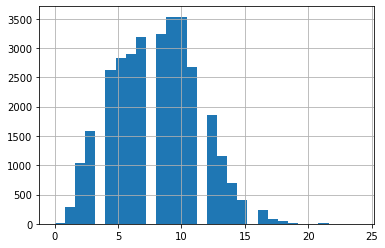

In [34]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df.cleaned_tweet]

pd.Series(seq_len).hist(bins = 30)

Keeping the padding length as 24.


In [35]:
# Splitting the data train and temp sets
train_X, temp_X, train_y, temp_y = train_test_split(train_df['cleaned_tweet'], train_df['label'],
                                                    test_size = 0.3,
                                                    stratify=train_df['label'])

# Splitting temp further to validation and test sets 
val_X, test_X, val_y, test_y = train_test_split(train_df['cleaned_tweet'], train_df['label'],
                                                    test_size = 0.3,
                                                    stratify=train_df['label'])

In [36]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [47]:
# Tokenization

tokens_train = tokenizer.batch_encode_plus(train_X.tolist(),
                                           padding = True,
                                           max_length = 24,
                                           truncation = True)

tokens_val = tokenizer.batch_encode_plus(val_X.tolist(),
                                           padding = True,
                                           max_length = 24,
                                           truncation = True)

tokens_test = tokenizer.batch_encode_plus(test_X.tolist(),
                                           padding = True,
                                           max_length = 24,
                                           truncation = True)

In [48]:
# Convert to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_labels = torch.tensor(train_y.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_labels = torch.tensor(val_y.tolist())


test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_labels = torch.tensor(test_y.tolist())


In [51]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
test_list = train_df.head(10).cleaned_tweet.tolist()
test_list

['father dysfunctional selfish drags kids dysfunction run',
 'thanks lyft credit use offer wheelchair vans pdx disapointed getthanked',
 'bihday majesty',
 'model love take time ur  ',
 'factsguide society motivation',
 '22 huge fan fare big talking leave chaos pay disputes get there allshowandnogo',
 'camping tomorrow danny',
 'next school year year exams think  school exams hate imagine actorslife revolutionschool girl',
 'won love land allin cavs champions cleveland clevelandcavaliers ',
 'welcome  gr8 ']

# BERT
1. Define Architecture and forward pass

In [ ]:
# importing the pre-trained model
bert = transformers.AutoModel.from_pretrained('bert-base-uncased')

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

CLASStorch.nn.Module[SOURCE]
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

```
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

```



In [ ]:
class BERT_Arch(nn.Module):

  def __init__(self,bert):
    
    # initialize the NN module
    super().__init__()

    self.bert = bert

    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(768,512)
    
    self.fc2 = nn.Linear(512,2)

    self.softmax = nn.LogSoftmax(dim = 1)

  def forward():


